In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import psycopg2

# settings
#datapath = '/Users/mirkoknoche/Google Drive/neuefische/projects/MIMIC/data/'
datapath = '/Users/mirkoknoche/MIMIC/'
gitpath = '/Users/mirkoknoche/Google Drive/neuefische/projects/MIMIC/'
pd.set_option('display.max_columns', 500)
%matplotlib inline
pd.options.display.float_format = '{:,}'.format

# database
conn_string = open(gitpath + 'intern/DB_connection.txt', 'r', encoding='UTF-8').read()

In [ ]:
import psycopg2
conn_string = open(gitpath + 'intern/DB_connection.txt', 'r', encoding='UTF-8').read()
conn = eval('psycopg2.connect({})'.format(conn_string.strip()))
sql = """select * from cpt 
        where subject_id in (select subject_id from diagnoses_icd di where ICD9_CODE = '51881')"""
df_sql = pd.read_sql(sql, conn)

conn.close()

# Datenbank

In [ ]:
import psycopg2
gitpath = '/Users/mirkoknoche/Google Drive/neuefische/projects/MIMIC/'
conn_string = open(gitpath + 'intern/DB_connection.txt', 'r', encoding='UTF-8').read()
conn = eval('psycopg2.connect({})'.format(conn_string.strip()))

In [ ]:
sql = """select * from vw_t_chartevents LIMIT 1000"""
df_sql = pd.read_sql(sql, conn)

In [ ]:
df_sql.head()

In [ ]:
df_sql.info()

In [ ]:
conn.close()

# Tests

## Change headerlines

In [ ]:
with open(datapath + 'liste_patienten.csv') as f:
    reader = csv.reader(f)
    data = list(reader)
    data = [x for x in data[0]]

In [ ]:
data

In [ ]:
cz = 7000000
chunk = pd.read_csv(datapath + 'chartevents.csv', nrows=100000) #, chunksize=cz)

In [ ]:
chunk.sample(10)

In [ ]:
for i, df in enumerate(chunk):
    print('Durchlauf ', i+1, 'gestarted.')
    df = df.loc[df.HADM_ID].isin(data)
    df.to_csv('{}chunk/ARDS{}.csv'.format(datapath, i), index=False)
    #df.loc[~df.HADM_ID].isin(data).to_csv('{}chunk/Other_{}.csv'.format(datapath, i), index=False)
    #df.to_csv('{}chunk/file{}.csv'.format(datapath, i), index=False)

## Read csv header

In [ ]:
df_csv = pd.read_csv(datapath + 'ards_aj.csv.gz', compression='gzip', usecols=[1], header=None)

In [ ]:
lst_count.append(len(df_csv))

In [ ]:
print(len(lst_count))
print(f'{sum(lst_count):,}')


In [ ]:
sql = """select row_id from chartevents"""
df_sql = pd.read_sql(sql, conn)


In [ ]:
len(df_sql)

In [ ]:
df_chart = pd.read_csv(datapath + 'chartevents.csv', usecols=[0]) #, chunksize=cz)

# inputevents_cv

Inputs are any fluids which have been administered to the patient: such as oral or tube feedings or intravenous solutions containing medications. 

Inputs exist in two separate tables: INPUTEVENTS_CV and INPUTEVENTS_MV. INPUTEVENTS_CV contains CareVue inputs, while INPUTEVENTS_MV contains Metavision inputs. Results from these tables can be unioned as observations are not duplicated across tables. For CareVue data, the rate and volume will be asynchronous, and only the CHARTTIME will be available. For rates, the CHARTTIME will correspond to a start time (when the drug was set to that rate). For volumes, the CHARTTIME will correspond to an end time.

| column | Description | Type |
|:-------|:------------|------|
| ROW_ID | ID from Database | numeric |
| SUBJECT_ID | Unique ID of a patient | numeric |
| HADM_ID | Unique ID of a patient hospital stay | numeric |
| ICUSTAY_ID | Unique ID of a patient ICU stay | numeric |
| CHARTTIME | time at which the measurement was charted at the bedside | datetime |
| ITEMID | Identifier for a single measurement type D_ITEMS.csv | numeric |
| AMOUNT | amount of a drug or substance administered to the patient either between the STARTTIME and ENDTIME | numeric |

In [ ]:
c = 1000000
df_input_cv = pd.read_csv(datapath + 'INPUTEVENTS_CV.csv', nrows=10000)

In [ ]:
sql = """select * from inputevents_cv 
        where subject_id in (select subject_id from diagnoses_icd di where ICD9_CODE = '51881')
        LIMIT 100000"""
df_input_cv = pd.read_sql(sql, conn)

In [ ]:
df_input_cv.shape

In [ ]:
df_input_cv.info()

We can see that already in the first 100000 rows some HADM_ID's are missing. Let us show how many, if we import only this column.

In [ ]:
sql = """select hadm_id from inputevents_cv """
df_test = pd.read_sql(sql, conn)

In [ ]:
df_test.shape

In [ ]:
df_test.isna().sum()

In [ ]:
print('Missing HADM_ID in percent: {:.2f}%'.format(float(df_test.isna().sum()) / df_test.shape[0] *100))

The amount of missing HADM_ID's ist tiny. We ignore these missing entrys.

In [ ]:
df_input_cv.head()

In [ ]:
sql = """select row_id from inputevents_cv """
df_test2 = pd.read_sql(sql, conn)

In [ ]:
df_test2.shape

In [ ]:
df_test2.nunique()

# Find extubations

In [2]:
conn = eval('psycopg2.connect({})'.format(conn_string.strip()))

In [3]:
sql = """select i2.hadm_id, v.* 
        from ventsettings v
        inner join icustays i2 on i2.icustay_id = v.icustay_id 
        where (v.mechvent + v.oxygentherapy + v.extubated + v.selfextubated) > 0
        order by icustay_id, charttime """
df = pd.read_sql(sql, conn)

In [4]:
df.shape

(592908, 7)

In [5]:
df.head(3)

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
0,189514,"200,006.0",2159-09-03 13:00:00,1,0,0,0
1,189514,"200,006.0",2159-09-03 16:50:00,1,0,0,0
2,189514,"200,006.0",2159-09-03 20:00:00,1,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592908 entries, 0 to 592907
Data columns (total 7 columns):
hadm_id          592908 non-null int64
icustay_id       592908 non-null float64
charttime        592908 non-null datetime64[ns]
mechvent         592908 non-null int64
oxygentherapy    592908 non-null int64
extubated        592908 non-null int64
selfextubated    592908 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 31.7 MB


Checking the exturbations

In [16]:
df.groupby('icustay_id').extubated.sum()

icustay_id
200,006.0    0
200,059.0    0
200,063.0    4
200,065.0    1
200,077.0    0
200,087.0    1
200,095.0    0
200,102.0    0
200,108.0    0
200,109.0    0
200,131.0    1
200,137.0    0
200,140.0    0
200,143.0    0
200,191.0    0
200,203.0    1
200,206.0    1
200,215.0    0
200,240.0    2
200,256.0    0
200,264.0    0
200,282.0    2
200,290.0    0
200,307.0    1
200,329.0    0
200,347.0    1
200,387.0    1
200,438.0    0
200,453.0    1
200,463.0    1
            ..
299,562.0    0
299,566.0    0
299,571.0    1
299,574.0    0
299,581.0    1
299,608.0    1
299,628.0    0
299,666.0    0
299,674.0    1
299,678.0    1
299,698.0    1
299,702.0    0
299,704.0    1
299,715.0    3
299,732.0    0
299,738.0    1
299,765.0    0
299,802.0    1
299,806.0    1
299,811.0    0
299,826.0    1
299,828.0    0
299,838.0    0
299,863.0    1
299,867.0    3
299,872.0    1
299,895.0    0
299,956.0    0
299,961.0    0
299,992.0    0
Name: extubated, Length: 7514, dtype: int64

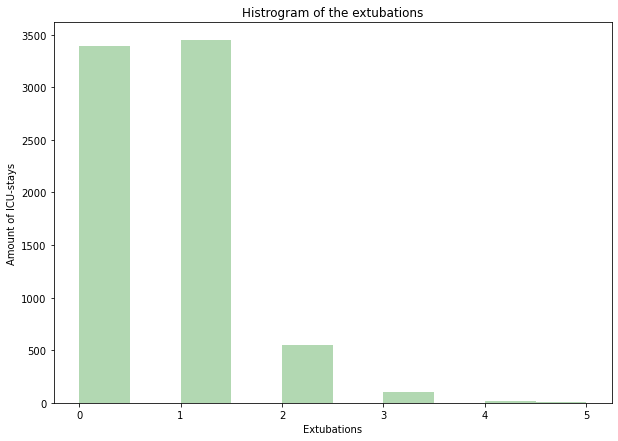

In [15]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.hist(df.groupby('icustay_id').extubated.sum(), color='g', alpha=0.3)
plt.ylabel('Amount of ICU-stays')
plt.xlabel('Extubations')
plt.title('Histrogram of the extubations')
plt.savefig('./images/hist_extubations_per_icustay.png')
plt.show();

Many ICU stays have no explicit documented

In [ ]:
df_qry = df[df.icustay_id == 200063]

In [ ]:
df_qry.head()

In [ ]:
df_qry['extube'] = df_qry['mechvent'].diff()
df_qry['extube'] = df_qry['extube'].pow(2)

In [ ]:
df_qry['oxy'] = df_qry['oxygentherapy'].diff()
df_qry['oxy'] = df_qry['oxy'].pow(2)

In [ ]:
df_qry.extube.fillna(0, inplace=True)
df_qry.oxy.fillna(0, inplace=True)

In [ ]:
df_qry.loc[160:180]

In [ ]:
df_qry[[df_qry['extube'] > 0] or [df_qry['oxy'] > 0]]

In [ ]:
conn.close()